In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from astropy.time import Time
from astropy.coordinates import Distance
from astropy import units as u
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const

In [2]:
base_dir = Path().absolute()
data_dir = os.path.join(base_dir, "data")

In [3]:
t_peak_mjd = Time(58603.87, format="mjd")
t_neutrino = Time("2019-10-01T20:09:18.17", format='isot', scale='utc')

bran_z = 0.0512

xpath = os.path.join(data_dir, "BranStark.dat")
# with open(xpath, "r") as f:
#     print(f.read())

In [4]:
df = pd.read_table(xpath, skiprows=4, sep="\s+")
print(df)

     #day_since_peak   band   flux_Jy       nu_rest           lum  \
0           15.54514   UVW2  0.000517  1.569084e+15  9.392264e+43   
1           19.23147   UVW2  0.000463  1.569084e+15  8.409503e+43   
2           22.20333   UVW2  0.000422  1.569084e+15  7.669557e+43   
3           25.16893   UVW2  0.000411  1.569084e+15  7.460541e+43   
4           28.24098   UVW2  0.000411  1.569084e+15  7.460541e+43   
..               ...    ...       ...           ...           ...   
191         34.81478  r.ZTF  0.000159  4.961606e+14  5.833004e+42   
192         38.61815  r.ZTF  0.000151  4.961606e+14  5.556640e+42   
193         44.28862  r.ZTF  0.000145  4.961606e+14  5.302641e+42   
194         47.13955  r.ZTF  0.000138  4.961606e+14  5.057923e+42   
195         56.65696  r.ZTF  0.000125  4.961606e+14  4.573959e+42   

          err_lum        lum_kc        lum_bb  
0    2.595179e+42  1.217448e+43  2.614296e+44  
1    4.647263e+42  1.105933e+43  2.270555e+44  
2    3.531962e+42  1.022367

In [5]:
meerkat_path = os.path.join(data_dir, "at2019dsg_MeerKAT.txt")
meerkat_data = pd.read_table(meerkat_path, sep="\s+")
print(meerkat_data)

       #mjd           date  flux_mJy  flux_err_mJy
0  58653.08  2019-Jun-19.1     0.104          0.18
1  58694.00  2019-Jul-30.0     0.111          0.17
2  58761.79  2019-Oct-05.8     0.152          0.19


In [6]:
radio_data = [x for x in os.listdir(data_dir) if "at2019dsg_20" in x]
print(radio_data)
vla_data = []
for x in radio_data:
    with open(os.path.join(data_dir, x), "r") as f:
        print(x)
        rawdate = (x.split("_")[1][:8])
        obs_date = Time("{0}-{1}-{2}T00:00:00.00".format(rawdate[:4], rawdate[4:6], rawdate[6:]), format='isot', scale='utc')
        for line in f.readlines():
            line = line.replace("\n", "")
            vla_data.append(tuple([obs_date.mjd] +  [float(x) for x in line.split(" ")]))
            
vla_data = pd.DataFrame(vla_data, columns=["mjd", "frequency", "flux", "flux_err"])
print(vla_data)
#             vla_data.append()
#         print(f.read())

['at2019dsg_20190808.txt', 'at2019dsg_20190522.txt', 'at2019dsg_20191005.txt', 'at2019dsg_20190619.txt']
at2019dsg_20190808.txt
at2019dsg_20190522.txt
at2019dsg_20191005.txt
at2019dsg_20190619.txt
        mjd  frequency   flux  flux_err
0   58703.0   2.243000  0.249     0.064
1   58703.0   2.755001  0.345     0.050
2   58703.0   3.179001  0.255     0.047
3   58703.0   3.691001  0.419     0.037
4   58703.0   4.737001  0.698     0.030
5   58703.0   5.761001  0.829     0.033
6   58703.0   6.687001  0.987     0.030
7   58703.0   7.711001  1.117     0.030
8   58703.0   8.487001  1.194     0.031
9   58703.0   9.511001  1.238     0.030
10  58703.0  10.137000  1.310     0.032
11  58703.0  11.161000  1.356     0.032
12  58625.0   8.487001  0.290     0.028
13  58625.0   9.511001  0.408     0.029
14  58625.0  10.487000  0.440     0.028
15  58625.0  11.511000  0.412     0.031
16  58761.0   2.243000  0.351     0.052
17  58761.0   2.755000  0.744     0.039
18  58761.0   3.243001  0.920     0.034
19 

In [7]:
# Formula from https://arxiv.org/abs/1510.01226

print(Distance(z=bran_z), cosmo.luminosity_distance(z=bran_z))

peak_f = []
peak_flux = []
dates = []
for date in sorted(list(set(vla_data["mjd"]))):
    data = vla_data[vla_data["mjd"] == date]
    max_index = list(data["flux"]).index(max(data["flux"]))
    peak_f.append(list(data["frequency"])[max_index])
    peak_flux.append(max(data["flux"]))
    dates.append(date)
dates = np.array(dates)
    
peak_f = np.array(peak_f)
peak_flux = np.array(peak_flux)

# f_a = 1.0 for spherical or 0.1 for conical

# Volume is shell of radius 0.1
f_v = 4./3. * (1.**3 - 0.9**3.)

# volume_of_cone = 4/3 pi r^3 times ratio of cone area to sphere surface area
# Volume of cone is thus f_v * f_a

# Works for spherical case now :)

def equipartition_radius(peak_f_ghz, peak_flux_mjy, f_a=1.0, z=bran_z):
    return (3.2 * 10**15) * u.cm * (
        (peak_flux_mjy ** (9./19.)) * 
        ((cosmo.luminosity_distance(z=z).to(u.cm)/(u.cm * 10**26))**(18./19.)) *
        ((peak_f_ghz/10.) ** -1.) * 
        ((1 + z) ** (-10./19.)) * 
        (f_a ** (-8./19.)) * 
        ((f_v * f_a) ** (-1./19.))
    ) * 4.**(1./19.)
    
def equipartition_energy(peak_f_ghz, peak_flux_mjy, f_a=1.0, z=bran_z):
    return (1.9 * 10**46) * u.erg * (
        (peak_flux_mjy ** (23./19.)) * 
        ((cosmo.luminosity_distance(z=z).to(u.cm)/(u.cm * 10**26))**(46./19.)) *
        ((peak_f_ghz/10.) ** -1.) * 
        ((1 + z) ** (-42./19.)) * 
        (f_a ** (-12./19.)) * 
        ((f_v * f_a) ** (8./19.))
    )* 4.**(11./19.)

# Cross check with table 2 of the paper, using row 2 of the spherical section

print("Checking formula using values from https://arxiv.org/abs/1510.01226")

asassn_14li_z = 0.0206
print("Distance to ASASSN-14li: {0:.2f} \n".format(Distance(z=asassn_14li_z).to(u.Mpc)))

published_r_s = 1.47 * 10**16 * u.cm
calc_r_s = equipartition_radius(8.20, 1.76, z=asassn_14li_z)
published_e_s = 7.8 * 10**47 * u.erg
calc_e_s = equipartition_energy(8.20, 1.76, z=asassn_14li_z)

published_r_c = 4.37 * 10**16 * u.cm
calc_r_c = equipartition_radius(8.20, 1.76, z=asassn_14li_z, f_a=0.1)
published_e_c = 3.19 * 10**47 * u.erg
calc_e_c = equipartition_energy(8.20, 1.76, z=asassn_14li_z, f_a=0.1)

# published_e = 9.5 * 10**47 * u.erg
# calc_e = equipartition_energy(4.37, 1.23, z=asassn_14li_z)

print("Spherical Case")

print("Checking with ASSASSN-14li, we should have Equipartition Radius of {0:.3g}.".format(published_r_s))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_r_s, calc_r_s/published_r_s))
print("Checking with ASSASSN-14li, we should have Equipartition Energy of {0:.3g}.".format(published_e_s))
print("We find {0:.3g}, a ratio of {1:.2f} \n".format(calc_e_s, calc_e_s/published_e_s))

print("Conical Case")

print("Checking with ASSASSN-14li, we should have Equipartition Radius of {0:.3g}.".format(published_r_c))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_r_c, calc_r_c/published_r_c))
print("Checking with ASSASSN-14li, we should have Equipartition Energy of {0:.3g}.".format(published_e_c))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_e_c, calc_e_c/published_e_c))

235.34004597982002 Mpc 230.17365539630913 Mpc
Checking formula using values from https://arxiv.org/abs/1510.01226
Distance to ASASSN-14li: 92.60 Mpc 

Spherical Case
Checking with ASSASSN-14li, we should have Equipartition Radius of 1.47e+16 cm.
We find 1.52e+16 cm, a ratio of 1.03
Checking with ASSASSN-14li, we should have Equipartition Energy of 7.8e+47 erg.
We find 7.67e+47 erg, a ratio of 0.98 

Conical Case
Checking with ASSASSN-14li, we should have Equipartition Radius of 4.37e+16 cm.
We find 4.51e+16 cm, a ratio of 1.03
Checking with ASSASSN-14li, we should have Equipartition Energy of 3.19e+47 erg.
We find 1.25e+48 erg, a ratio of 3.91


In [8]:
delta_times = (dates[1:] - dates[:-1]) * u.day

def calc_av_expansion(peak_f, peak_flux, f_a=1):
    rads = equipartition_radius(peak_f, peak_flux, f_a)
    delta_rad = rads[1:] - rads[:-1]
    vel = (delta_rad / delta_times).to("m s-1")
    return vel

# beta = vel/(3 * 10 ** 8 *u.m/u.s)
# print(beta)
# print(vel.to("km s-1"))
offset_times = dates[:-1] + 0.5 * delta_times / u.day
# print(offset_times)

In [9]:
bands = list(set(df["band"]))
print(bands)

['r.SEDM', 'UVM2', 'UVW2', 'g.ZTF', 'r.IOO', 'g.IOO', 'r.ZTF', 'UVW1', 'U', 'B']


In [10]:
def convert_radio(flux_mjy, frequency_ghz):
    flux_jy = 10**-3 * flux_mjy
    frequency_hz = 10**9 * frequency_ghz
    return 10**-23 * flux_jy * frequency_hz

def convert_to_mjy(energy_flux, frequency_ghz):
    frequency_hz = 10**9 * frequency_ghz
    return 10 ** 3 * 10 ** 23 * energy_flux / frequency_hz

print(convert_to_mjy(convert_radio(1., 1.), 1.))


1.0000000000000002


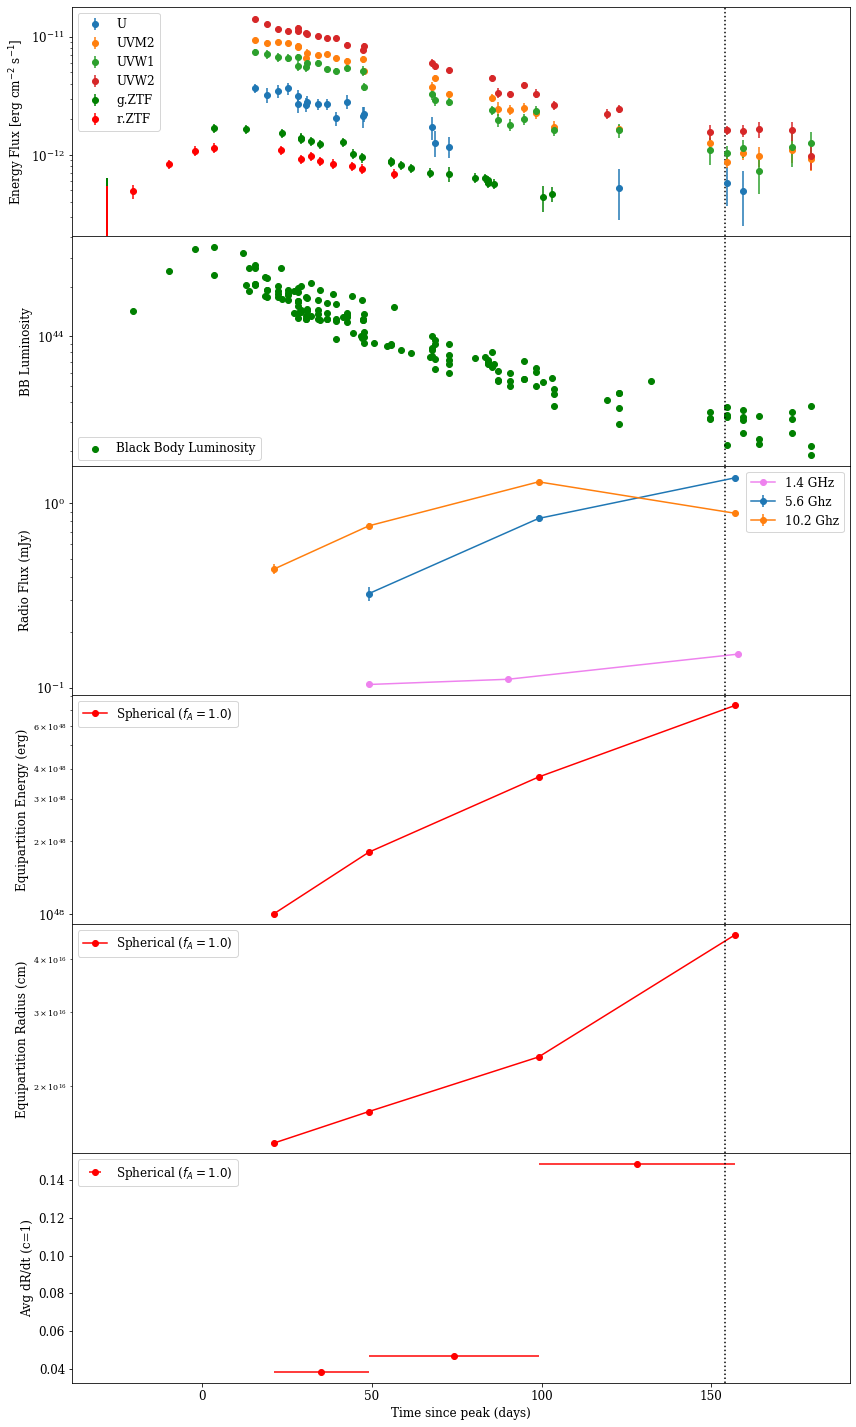

In [14]:
plt.figure(figsize=(12, 20))

ax1 = plt.subplot(611)

dl = Distance(z=bran_z).to("cm").value
area = 4 * np.pi * (dl ** 2)

conversion = 1./area

colors = {
    "r.IOO": "r",
    "r.ZTF": "r",
    "r.SEDM": "r",
    "g.ZTF": "g",
    "g.IOO": "g"
}

# Plot luminosity

for band in sorted(bands):
    data = df[df["band"] == band]
    
    if band in colors:
        c = colors[band]
    else:
        c = None
    
    ax1.errorbar(data["#day_since_peak"], conversion * data["lum"], yerr=conversion *data["err_lum"], color=c,  fmt='o', label=band)

# ax1.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, convert_radio(meerkat_data["flux_mJy"], 1.4), marker="o", color="violet", label="1.4 GHz")

# for frequency in [10.2]:
#     data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
#     data = data.sort_values("mjd")
#     ax1.errorbar(data["mjd"]- t_peak_mjd.mjd, convert_radio(data["flux"], frequency),  yerr=convert_radio(data["flux_err"], frequency), marker="o", label="{0} Ghz".format(frequency))

# ax1.set_ylabel("Luminosity", fontsize=12)
ax1.set_ylabel(r"Energy Flux [erg cm$^{-2}$ s$^{-1}$]", fontsize=12)
ax1.legend(fontsize=12)
ax1.set_yscale("log")
ax1.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":", label="IC191001A")
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Black Body Luminosity

ax2 = plt.subplot(612, sharex=ax1)
ax2.scatter(df["#day_since_peak"][df["lum_bb"] > 0], df["lum_bb"][df["lum_bb"] > 0], color="green", label="Black Body Luminosity")

ax2.set_yscale("log")
ax2.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax2.set_ylabel("BB Luminosity", fontsize=12)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)


# Radio Data

ax3 = plt.subplot(613, sharex=ax1)
ax3.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, meerkat_data["flux_mJy"], marker="o", color="violet", label="1.4 GHz")
ax3.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")

for frequency in [5.6, 10.2]:
    data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
    data = data.sort_values("mjd")
    ax3.errorbar(data["mjd"]- t_peak_mjd.mjd, data["flux"],  yerr=data["flux_err"], marker="o", label="{0} Ghz".format(frequency))

ax3.legend(fontsize=12)
ax3.set_ylabel("Radio Flux (mJy)", fontsize=12)
ax3.set_yscale("log")
ax3.tick_params(axis='both', which='major', labelsize=12)

# Equipartition Energy

ax4 = plt.subplot(614, sharex=ax1)

# ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux),  marker="o", color="gray", label=r"Spherical ($f_{A}=1.0$)")
# ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="gray", label=r"Conical ($f_{A}=0.1$)")
ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux),  marker="o", color="red", label=r"Spherical ($f_{A}=1.0$)")
# ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux, f_a=0.1),  marker="*", color="blue", label=r"Conical ($f_{A}=0.1$)")
ax4.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax4.set_yscale("log")
ax4.set_ylabel("Equipartition Energy (erg)", fontsize=12)
ax4.legend(fontsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)

# Equipartition Radius

ax5 = plt.subplot(615, sharex=ax1)
# ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux), marker="o", color="brown", label=r"Spherical ($f_{A}=1.0$)")
# ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="brown", label=r"Conical ($f_{A}=0.1$)")
ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux), marker="o", color="red", label=r"Spherical ($f_{A}=1.0$)")
# ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux, f_a=0.1),  marker="*", color="blue", label=r"Conical ($f_{A}=0.1$)")

ax5.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax5.set_yscale("log")
ax5.set_ylabel("Equipartition Radius (cm)", fontsize=12)
ax5.legend(fontsize=12)
ax5.tick_params(axis='both', which='major', labelsize=12)


# Average Expansion Velocity


ax6 = plt.subplot(616, sharex=ax1)
# ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=1.0)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="blue", label=r"Spherical ($f_{A}=1.0$)")
# eb1 = ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=0.1)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="blue", marker="*", label=r"Conical ($f_{A}=0.1$)")
# eb1[-1][0].set_linestyle(':')
ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=1.0)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="red", label=r"Spherical ($f_{A}=1.0$)")
# eb1 = ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=0.1)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="blue", marker="*", label=r"Conical ($f_{A}=0.1$)")

ax6.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax6.set_ylabel(r"Avg dR/dt (c=1)", fontsize=12)
ax6.legend(fontsize=12)

plt.xlabel("Time since peak (days)", fontsize=12)
ax6.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=.0)

Text(0.5, 0, 'Time since peak (days)')

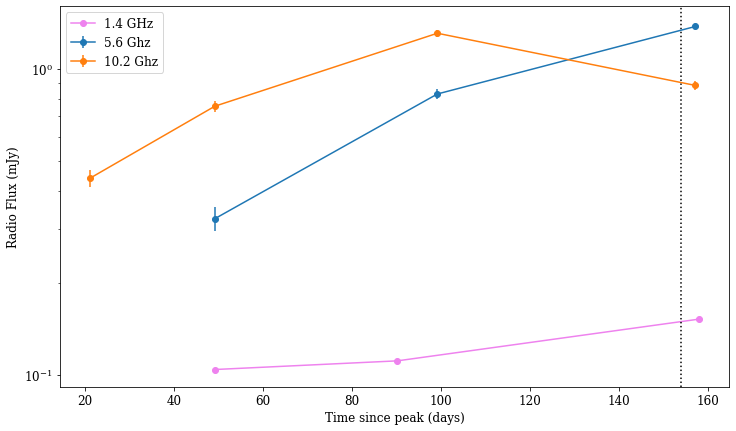

In [15]:
plt.figure(figsize=(12, 7))

# Radio Data

ax3 = plt.subplot(111)
ax3.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, meerkat_data["flux_mJy"], marker="o", color="violet", label="1.4 GHz")
ax3.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")

for frequency in [5.6, 10.2]:
    data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
    data = data.sort_values("mjd")
    ax3.errorbar(data["mjd"]- t_peak_mjd.mjd, data["flux"],  yerr=data["flux_err"], marker="o", label="{0} Ghz".format(frequency))

ax3.legend(fontsize=12)
ax3.set_ylabel("Radio Flux (mJy)", fontsize=12)
ax3.set_yscale("log")
ax3.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel("Time since peak (days)", fontsize=12)


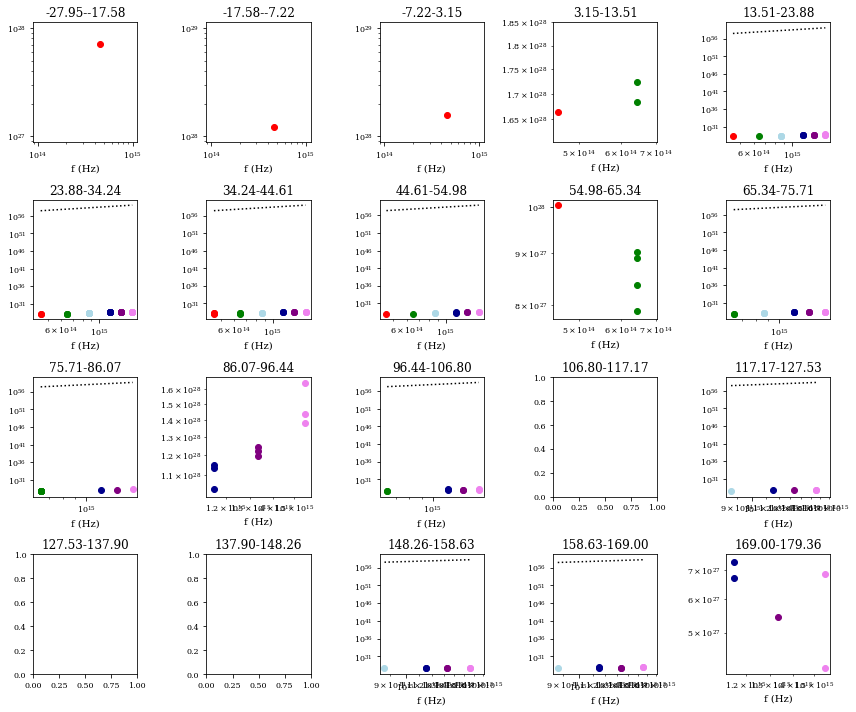

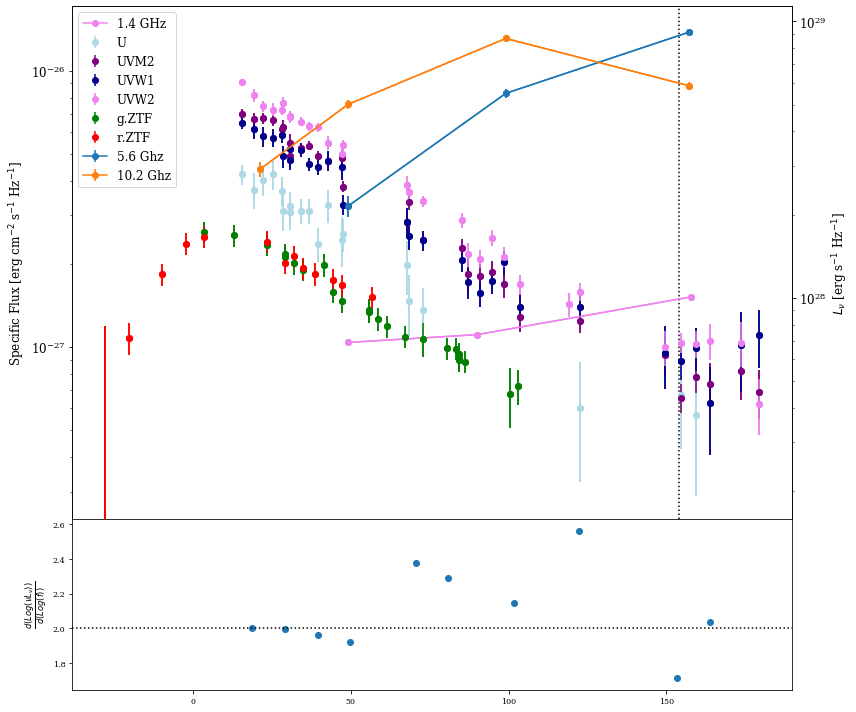

In [22]:
dl = Distance(z=bran_z).to("cm").value
area = 4 * np.pi * (dl ** 2)

conversion = 1./area

colors = {
    "r.IOO": "r",
    "r.ZTF": "r",
    "r.SEDM": "r",
    "g.ZTF": "g",
    "g.IOO": "g",
    "UVW2": "violet",
    "UVM2": "purple",
    "UVW1": "darkblue",
    "U": "lightblue",
    
}

times = []
delta_lum = []

bands = {
    "U": 3465 * u.angstrom,
    "UVW1": 2600 * u.angstrom,
    "UVM2": 2246 * u.angstrom,
    "UVW2": 1928 * u.angstrom,
    "g.ZTF": 464 * u.nm,
    "r.ZTF": 658 * u.nm,
}

plt.figure(figsize=(12, 10))
bins = np.linspace(min(df["#day_since_peak"]), max(df["#day_since_peak"]), 21)

start_bin = 5

photon_index = []
index_times = []


for j, lower in enumerate(bins[:-1]):
    ax = plt.subplot(4, 5, j+1)
    upper = bins[j + 1]
        
    mask = np.logical_and(
        df["#day_since_peak"] > lower,
        df["#day_since_peak"] < upper,
    )
    
    plt.title("{0:.2f}-{1:.2f}".format(lower, upper))
            
    data = df[mask]
    
    fs = []
    lums = []

    for band in list(set(data["band"][mask])):
        if band in bands:
            wl = bands[band].to("m")
            f = (const.c / wl).to("Hz")

            bd = data[data["band"] == band]["lum"]
#             err = data[data["band"] == band]["lum"]
            bd = np.array(list(bd[bd > 0]))
    
            c = colors[band]
        
            for y in bd:
                ax.scatter(f, y/f.value, color=c)
            plt.xlabel("f (Hz)")
            ax1.set_ylabel(r"$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]", fontsize=12)
            fs.append(f.value)
            lums.append(np.mean(bd))
            plt.xscale("log")
            plt.yscale("log")
            
    if len(fs) > 3:
    
        grad = (np.log(max(lums)) - np.log(min(lums)))/(np.log(max(fs)) - np.log(min(fs)))

        x = [min(fs), max(fs)]
        y = [min(lums), np.exp(np.log(min(lums)) + grad * (np.log(max(fs)) - np.log(min(fs))))]

        plt.plot(x, np.array(y)*np.array(x), color="k", linestyle=":")

        index_times.append(np.mean([lower, upper]))
        photon_index.append(grad)
            
plt.tight_layout()

plt.figure(figsize=(12, 10))

ax1 = plt.subplot2grid((4, 1), (0, 0), colspan=3, rowspan=3)
ax1b = ax1.twinx()

# Plot luminosity

for band in sorted(bands):
    if band in bands:
        c = colors[band]
        data = df[df["band"] == band]
        wl = bands[band].to("m")
        f = (const.c / wl).to("GHz")
        flux = conversion * data["lum"]
        f_convert = f.to("Hz").value
        lum = data["lum"]/ f_convert
        ax1b.errorbar(data["#day_since_peak"], lum, yerr=data["err_lum"]/f_convert, color=c,  fmt='o', label=band)
        ax1.errorbar(data["#day_since_peak"], flux/f_convert, yerr=conversion *data["err_lum"]/f_convert, color=c,  fmt='o', label=band)

ax1.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, convert_radio(meerkat_data["flux_mJy"], 1.4)/(1.4 * 10 ** 9), marker="o", color="violet", label="1.4 GHz")
ax1b.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, convert_radio(meerkat_data["flux_mJy"], 1.4)/(1.4 * 10 ** 9)/conversion, marker="o", color="violet", label="1.4 GHz")

for frequency in [5.6, 10.2]:
    data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
    data = data.sort_values("mjd")
    ax1.errorbar(data["mjd"]- t_peak_mjd.mjd, convert_radio(data["flux"], frequency)/(frequency * 10**9),  yerr=convert_radio(data["flux_err"], frequency)/(frequency * 10**9), marker="o", label="{0} Ghz".format(frequency))
    ax1b.errorbar(data["mjd"]- t_peak_mjd.mjd, convert_radio(data["flux"], frequency)/(frequency * 10**9)/conversion,  yerr=convert_radio(data["flux_err"], frequency)/(frequency * 10**9)/conversion, marker="o", label="{0} Ghz".format(frequency))


ax1.set_ylabel(r"Specific Flux [erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$]", fontsize=12)
ax1b.set_ylabel(r"$L_{\nu}$ [erg s$^{-1}$ Hz$^{-1}$]", fontsize=12)
ax1.legend(fontsize=12)
ax1.set_yscale("log")
ax1b.set_yscale("log")
ax1.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":", label="IC191001A")
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1b.tick_params(axis='both', which='major', labelsize=12)

ax2 = plt.subplot2grid((4, 1), (3, 0), colspan=3, rowspan=1, sharex=ax1)
ax2.scatter(index_times, photon_index)
ax2.set_ylabel(r"$\frac{d(Log(\nu L_{\nu}))}{d(Log(f))}$", fontsize=12)
plt.axhline(2.0, color="k", linestyle=":")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
